# Imports

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
from qiskit.synthesis import synth_clifford_depth_lnn
from qiskit.quantum_info import random_unitary
from qiskit.circuit.library import UnitaryGate
from qiskit import transpile
import numpy as np
from qiskit.transpiler import OptimizationMetric

# Global Methods

In [100]:
def get_t_count(circuit):
    """Count the number of T and T† gates in a quantum circuit."""
    t_count = 0
    for instr, _, _ in circuit:
        if instr.name in ['t', 'tdg']:
            t_count += 1
    return t_count

## gridsynth

In [195]:
def apply_gridsynth_to_circuit(circuit, qubit, gridsynth_string):
    """
    Apply a gridsynth rotation sequence to an existing circuit.

    Args:
    circuit: Existing QuantumCircuit
    qubit_index: Which qubit to apply gates to
    gridsynth_string: Output string from gridsynth
    """
    # Apply gates from right to left
    for gate in reversed(gridsynth_string.upper()):
        if gate == 'T':
            circuit.t(qubit)
        elif gate == 'S':
            circuit.s(qubit)
        elif gate == 'H':
            circuit.h(qubit)
        elif gate == 'X':
            circuit.h(qubit)
            circuit.s(qubit)
            circuit.s(qubit)
            circuit.h(qubit)
            # circuit.x(qubit)
            # pass
        elif gate == 'W':
            circuit.global_phase += np.pi/4
            # pass
    return circuit  

In [136]:
import subprocess

def run_gridsynth(angle, random_seed=40) -> str:
    """
    Run gridsynth and return the output string.
    
    Args:
        angle: Angle expression as string (e.g., "pi/4", "-2*pi/7")
    
    Returns:
        Gridsynth output string
    """
    result = subprocess.run(
        [r"C:\cabal\bin\gridsynth.exe", angle, f"-r {random_seed}"],
        capture_output=True,
        text=True
    )
    return result.stdout.strip()

def run_gridsynth(angle, options=None) -> str:
    """
    Run gridsynth and return the output string.
    
    Args:
        angle: Angle expression as string (e.g., "pi/4", "-2*pi/7")
        options: List of option strings (e.g., ["-d", "100"])
    
    Returns:
        Gridsynth output string
    """
    cmd = [r"C:\cabal\bin\gridsynth.exe"]
    if options:
        cmd.extend(options)
    cmd.append(angle)
    
    result = subprocess.run(cmd, capture_output=True, text=True)
    return result.stdout.strip()


### Testing gridsynth

In [249]:
run_gridsynth("pi/4")  

'HTHTSHTHTHTSHTHTHTSHTSHTHTSHTHTHTHTHTSHTSHTHTSHTSHTSHTSHTSHTSHTHTHTHTSHTSHTHTSHTHTSHTHTSHTSHTHTSHTSHTHTSHTHTHTHTHTSHTSHTHTHTHTSHTHTHTHTHTHTHTHTSHTHTSHTHTSHTSHTSHTSHTHTSHTSHTSHTHTHTSHTHTHTHTHTHTHTHTSHTSHTHTSHTHTSHTSHTSHTSHTHTHTSHTSHTHTSHTHTHTSHTHTHTHTSHTSHTSHTHTSHTSHTHTHTSHTHTSHTHTHTSHTHTSHTSHTHTSHTSHTHTSHTSHTHTSHTSHTSHSSS'

In [250]:
qc = QuantumCircuit(1)
qc.rz(np.pi / 4, 0)
u = Operator(qc)

In [253]:
gridsynth_output = "HTHTSHTSHTSHTHTSHTSHTHTSHTHTHTHTHTHTSHTHTSHTHTHTSHTSHTSHTHTHTSHTSHTHTHTSHTHTHTSHTSHTHTSHTHTSHTHTHTHTSHTSHTHTSHTHTHTHTSHTHTSHTSHTHTHTSHTSHTSHTHTHTSHTHTHTHTSHTHTSHTSHTSHTHTSHTHTSHTSHTHTSHTHTSHTSHTHTHTHTSHTSHTHTSHTHTHTSHTSHTHTHTSHTHTHTHTHTSHTHTSHTSHTSHTHTHTHTHTHTSHTHTSHTSHTSHTSHTHTSHTSHTSHTSHTHTHTHTHTSHTHTSHTHTHTSHTHTHXSSWWWWWW"

# Create a quantum circuit
qc = QuantumCircuit(1)

# Apply the gridsynth sequence to qubit 0
grid_synth_qc = apply_gridsynth_to_circuit(qc, 0, run_gridsynth("pi/4"))

# grid_synth_qc.draw()

u_gridsynth = Operator(grid_synth_qc)

In [254]:
u_gridsynth.equiv(u)  

True

# Challenge 1

In [214]:
# Challenge 1

qc = QuantumCircuit(2)

# Controlled-Y: control qubit 0, target qubit 1
qc.cy(1, 0)

optimizationMetric = OptimizationMetric(2)

# 3. Transpile to H, T, T†, CNOT
transpiled = transpile(
    qc,
    basis_gates=['h', 't', 'tdg', 'cx', 's', 'sdg'],
    optimization_level=3,
    
)

# 4. Count T gates
t_count = transpiled.count_ops().get('t', 0) + \
          transpiled.count_ops().get('tdg', 0)

print(f"T-count: {t_count}")



print(qc.draw())
print(transpiled.draw())

T-count: 0
     ┌───┐
q_0: ┤ Y ├
     └─┬─┘
q_1: ──■──
          
     ┌───┐┌───┐┌───┐┌───┐┌───┐
q_0: ┤ S ├┤ S ├┤ S ├┤ X ├┤ S ├
     └───┘└───┘└───┘└─┬─┘└───┘
q_1: ─────────────────■───────
                              


## Testing challenge 1

In [216]:
qc2 = QuantumCircuit(2)
# qc2.tdg(1)
# qc2.tdg(1)
# qc2.cx(0, 1)
# qc2.t(1)
# qc2.t(1)

qc2.sdg(0)
qc2.cx(1, 0)
qc2.s(0)


print(qc2.draw())

     ┌─────┐┌───┐┌───┐
q_0: ┤ Sdg ├┤ X ├┤ S ├
     └─────┘└─┬─┘└───┘
q_1: ─────────■───────
                      


In [217]:
op1 = Operator(qc)
op2 = Operator(qc2)
print(op1.equiv(op2))
transpiled_op = Operator(transpiled)
op1.equiv(transpiled_op)
op1

True
Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
          [0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [89]:
ts = QuantumCircuit(1)
ts.t(0)
ts.t(0)
ts.t(0)
ts.t(0)
ts.t(0)
ts.t(0)
ts_op = Operator(ts)

sdgs = QuantumCircuit(1)
sdgs.sdg(0)
sdgs_op = Operator(sdgs)

ts_op.equiv(sdgs_op)

True

In [87]:
stop

NameError: name 'stop' is not defined

# Challenge 2

In [193]:
run_gridsynth("pi/7", ["-d", "100"])

'HTSHTSHTSHTHTSHTHTSHTHTSHTHTHTSHTHTSHTSHTSHTHTSHTHTHTSHTSHTSHTSHTSHTHTSHTHTHTSHTHTHTSHTSHTHTHTHTHTSHTSHTHTHTHTHTHTSHTHTHTHTSHTSHTHTSHTSHTHTHTHTHTHTSHTHTSHTHTHTSHTSHTSHTSHTSHTSHTHTSHTHTSHTHTSHTSHTHTHTSHTHTHTHTSHTHTSHTSHTSHTSHTSHTSHTSHTSHTSHTSHTHTHTSHTSHTSHTSHTHTHTHTHTHTHTSHTHTSHTSHTSHTSHTHTHTHTHTSHTHTSHTHTSHTSHTSHTSHTSHTHTSHTHTSHTHTHTHTSHTHTSHTSHTSHTHTHTSHTHTHTHTHTHTHTSHTSHTHTHTHTSHTSHTSHTSHTHTHTSHTSHTSHTSHTSHTSHTHTHTHTHTSHTSHTHTHTSHTHTHTSHTHTHTHTHTSHTHTHTHTHTHTHTSHTHTHTHTHTHTSHTSHTSHTHTSHTHTHTSHTHTSHTHTSHTHTSHTSHTSHTSHTHTSHTHTSHTSHTSHTHTSHTHTSHTSHTSHTHTSHTHTSHTSHTSHTSHTSHTHTSHTHTHTSHTSHTSHTSHTHTHTHTHTSHTHTSHTHTHTHTHTHTHTSHTHTSHTHTHTHTSHTSHTSHTSHTSHTSHTHTHTSHTHTHTHTHTHTHTHTHTHTSHTSHTSHTHTHTSHTSHTHTHTHTSHTSHTHTSHTHTHTSHTHTSHTHTSHTSHTSHTSHTHTSHTSHTSHTSHTHTSHTSHTHTHTHTSHTHTSHTHTHTHTSHTHTHTSHTHTSHTHTSHTSHTSHTHTSHTSHTHTHTHTSHTHTSHTHTHTSHTSHTHTHTHTSHTSHTHTHTSHTHTSHTSHTSHTHTHTSHTSHTHTSHTSHTHTHTHTSHTSHTHTHTSHTSHTHTHTSHTSHTSHTSHTSHTSHTHTSHTSHTHTSHTSHTHTHTSHTHTSHTSHTSHTSHTHTSHTHTHTSHTSHTHTSHTSHT

In [305]:
qc_2_default = QuantumCircuit(2)
qc_2_default.cry(np.pi / 7, 0, 1)

transpiled_qc_2_default = transpile(
    qc_2_default,
    basis_gates=['s', 'cx', 'h', 'rz'],
    optimization_level=3,
)

print(transpiled_qc_2_default)

                                                                              »
q_0: ───────────────────────────────────■─────────────────■───────────────────»
     ┌───┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌───────────┐┌─┴─┐┌───┐┌──────────┐»
q_1: ┤ H ├┤ Rz(π/2) ├┤ H ├┤ Rz(π/14) ├┤ X ├┤ Rz(-π/14) ├┤ X ├┤ H ├┤ Rz(-π/2) ├»
     └───┘└─────────┘└───┘└──────────┘└───┘└───────────┘└───┘└───┘└──────────┘»
«          
«q_0: ─────
«     ┌───┐
«q_1: ┤ H ├
«     └───┘


In [324]:
def qc_2_circuit(d_level):
    qc_2 = QuantumCircuit(2)
    qc_2.h(1)
    qc_2 = apply_gridsynth_to_circuit(qc_2, 1, run_gridsynth("pi/2", ["-d", str(d_level)])) # qc_2.rz(np.pi/2, 1)
    qc_2.h(1)
    qc_2 = apply_gridsynth_to_circuit(qc_2, 1, run_gridsynth("pi/14", ["-d", str(d_level)])) # qc_2.rz(np.pi/14, 1)
    qc_2.cx(0, 1)
    qc_2 = apply_gridsynth_to_circuit(qc_2, 1, run_gridsynth("0-pi/14", ["-d", str(d_level)])) # qc_2.rz(-np.pi/14, 1)
    qc_2.cx(0, 1)
    qc_2.h(1)
    qc_2 = apply_gridsynth_to_circuit(qc_2, 1, run_gridsynth("0-pi/2", ["-d", str(d_level)])) # qc_2.rz(-np.pi/2, 1)
    qc_2.h(1)

    # print(qc_2.draw())
    print(get_t_count(qc_2))
    qc_2_op = Operator(qc_2)
    return qc_2, qc_2_op

In [ ]:
u_target = QuantumCircuit(2)
u_target.cry(np.pi/7, 0, 1)
u_target_op = Operator(u_target)

print(get_t_count(qc_2))

print(u_target_op.equiv(qc_2_op))
print(u_target_op)
print(qc_2_op)

print(qc_2_op.data - u_target_op.data)
np.linalg.norm(qc_2_op.data - u_target_op.data)


104
False
Operator([[ 1.        +0.j,  0.        +0.j,  0.        +0.j,
            0.        +0.j],
          [ 0.        +0.j,  0.97492791+0.j,  0.        +0.j,
           -0.22252093+0.j],
          [ 0.        +0.j,  0.        +0.j,  1.        +0.j,
            0.        +0.j],
          [ 0.        +0.j,  0.22252093+0.j,  0.        +0.j,
            0.97492791+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
Operator([[ 1.00000000e+00-1.17137687e-06j,
            0.00000000e+00+0.00000000e+00j,
           -8.96133736e-06+6.12339842e-06j,
            0.00000000e+00+0.00000000e+00j],
          [ 0.00000000e+00+0.00000000e+00j,
            9.74928267e-01-4.61824814e-06j,
            0.00000000e+00+0.00000000e+00j,
           -2.22519378e-01+5.70926154e-06j],
          [ 8.96133736e-06+6.12339842e-06j,
            0.00000000e+00+0.00000000e+00j,
            1.00000000e+00+1.17137687e-06j,
            0.00000000e+00+0.00000000e+00j],
          [ 0.00000000e+00+0.00000000e+00j,
  

C:\Users\marlo_2lbtn5r\AppData\Local\Temp\ipykernel_756\339081247.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, _, _ in circuit:


np.float64(1.8742640253096343e-05)

C:\Users\marlo_2lbtn5r\AppData\Local\Temp\ipykernel_756\339081247.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, _, _ in circuit:


42
60
76
104
120
142
160
180
200
220
236
264
280
304
320
348
356
380
404
424
446
456
480
504
516
544
560
576
598
620
640
664
688
704
724
746
760
784
800
816
844
860
884
908
908
932
964
980


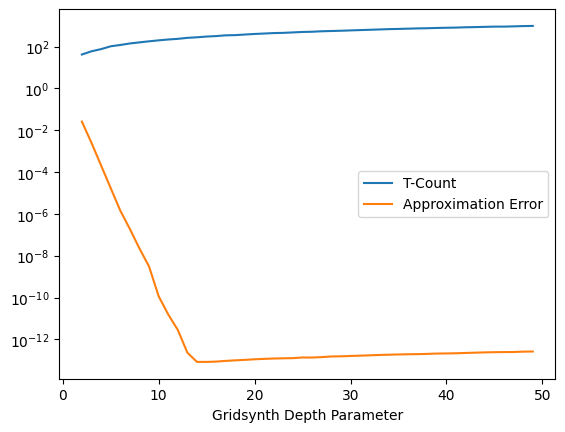

In [326]:
import matplotlib.pyplot as plt

d_range = range(2, 50, 1)
t_counts = []
errors = []

for d in d_range:
    qc_2, qc_2_op = qc_2_circuit(d)
    t_counts.append(get_t_count(qc_2))
    error = np.linalg.norm(qc_2_op.data - u_target_op.data)
    errors.append(error)

plt.plot(d_range, t_counts, label='T-Count')
plt.plot(d_range, errors, label='Approximation Error')
plt.yscale('log')
plt.xlabel('Gridsynth Depth Parameter')
plt.legend()

In [328]:
qc_2, qc_2_op = qc_2_circuit(13)
get_t_count(qc_2)
np.linalg.norm(qc_2_op.data - u_target_op.data)

264


C:\Users\marlo_2lbtn5r\AppData\Local\Temp\ipykernel_756\339081247.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, _, _ in circuit:


np.float64(2.3860756619184923e-13)

# Challenge 3

In [296]:
qc_3 = QuantumCircuit(2)
qc_3.cx(0, 1)
qc_3 = apply_gridsynth_to_circuit(qc_3, 1, run_gridsynth("12*pi/7")) # qc_3.rz(-2*np.pi/7, 1)
qc_3.cx(0, 1)

qc_3.draw()


global phase: 7π/4
                                                                           »
q_0: ──■───────────────────────────────────────────────────────────────────»
     ┌─┴─┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
q_1: ┤ X ├┤ S ├┤ S ├┤ S ├┤ H ├┤ S ├┤ S ├┤ H ├┤ H ├┤ S ├┤ T ├┤ H ├┤ T ├┤ H ├»
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
«q_1: ┤ S ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├»
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
«q_1: ┤ T ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ S ├┤ T ├»
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
«q_1: ┤ H ├┤ S ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ S ├┤ T ├»
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
«q_1: ┤ H ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├»
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
«q_1: ┤ S ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ S ├┤ T ├»
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
«q_1: ┤ H ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├»
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
«q_1: ┤ S ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ T ├┤ H ├┤ S ├»
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
«q_1: ┤ T ├┤ H ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ T ├»
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
«q_1: ┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ T ├┤ H ├┤ S ├┤ T ├┤ H ├┤ T ├»
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«                                                                           »
«q_0: ──

# Challenge 4

In [298]:
qc_4 = QuantumCircuit(2)
qc_4.h([0, 1])
qc_4.cx(0, 1)
qc_4 = apply_gridsynth_to_circuit(qc_4, 1, run_gridsynth("0-2*pi/7", ["-d", "10"])) # qc_4.rz(-2 * np.pi / 7, 1)
qc_4.cx(0, 1)
qc_4.h([0, 1])
qc_4.sdg([0,1])
qc_4.h([0, 1])
qc_4 = apply_gridsynth_to_circuit(qc_4, 1, run_gridsynth("0-2*pi/7", ["-d", "10"])) # qc_4.rz(-2 * np.pi / 7, 1)
qc_4.h([0, 1])
qc_4.s([0,1])

get_t_count(qc_4)
# print(qc_4.draw())

# transpiled_4 = transpile(
#     qc_4,
#     basis_gates=['h', 't', 'tdg', 'cx', 's', 'sdg',],
#     optimization_level=3
# )
# t_count_4 = get_t_count(transpiled_4)
# print(f"T-count for qc_4_transpiled: {t_count_4}")
# # print(transpiled_4.draw())

C:\Users\marlo_2lbtn5r\AppData\Local\Temp\ipykernel_756\339081247.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, _, _ in circuit:


196

In [236]:
"""Challenge 4 target matrix exp(i pi/7 (XX+YY)) = (I \otiimes H) exp(i pi/7 ZZ) (I \otimes H):
[[0.901-0.j     0.   +0.4339j 0.   +0.j     0.   +0.j    ]
 [0.   +0.4339j 0.901-0.j     0.   +0.j     0.   +0.j    ]
 [0.   +0.j     0.   +0.j     0.901+0.j     0.   -0.4339j]
 [0.   +0.j     0.   +0.j     0.   -0.4339j 0.901+0.j    ]]

Real part:
[[0.901 0.    0.    0.   ]
 [0.    0.901 0.    0.   ]
 [0.    0.    0.901 0.   ]
 [0.    0.    0.    0.901]]
Imag part:
[[-0.      0.4339  0.      0.    ]
 [ 0.4339 -0.      0.      0.    ]
 [ 0.      0.      0.     -0.4339]
 [ 0.      0.     -0.4339  0.    ]]"""

'Challenge 4 target matrix exp(i pi/7 (XX+YY)) = (I \\otiimes H) exp(i pi/7 ZZ) (I \\otimes H):\n[[0.901-0.j     0.   +0.4339j 0.   +0.j     0.   +0.j    ]\n [0.   +0.4339j 0.901-0.j     0.   +0.j     0.   +0.j    ]\n [0.   +0.j     0.   +0.j     0.901+0.j     0.   -0.4339j]\n [0.   +0.j     0.   +0.j     0.   -0.4339j 0.901+0.j    ]]\n\nReal part:\n[[0.901 0.    0.    0.   ]\n [0.    0.901 0.    0.   ]\n [0.    0.    0.901 0.   ]\n [0.    0.    0.    0.901]]\nImag part:\n[[-0.      0.4339  0.      0.    ]\n [ 0.4339 -0.      0.      0.    ]\n [ 0.      0.      0.     -0.4339]\n [ 0.      0.     -0.4339  0.    ]]'

In [292]:
true_op = [[0.901-0.j ,    0.   +0.4339j ,0.   +0.j  ,   0.   +0.j ,   ],
 [0.   +0.4339j ,0.901-0.j  ,   0.   +0.j ,    0.   +0.j    ],
 [0.   +0.j    , 0.   +0.j  ,   0.901+0.j    , 0.   -0.4339j],
 [0.   +0.j   ,  0.   +0.j,     0.   -0.4339j ,0.901+0.j    ]]

In [300]:
qc_4_op = Operator(qc_4)
print(qc_4_op.data)
np.linalg.norm(qc_4_op.data - true_op)

[[ 8.11744901e-01+2.13395968e-11j  3.70920794e-11+1.88255099e-01j
   3.90915741e-01-7.11681269e-11j -1.61299862e-11+3.90915741e-01j]
 [ 3.70920794e-11+1.88255099e-01j  8.11744901e-01+2.13395968e-11j
  -1.61299862e-11+3.90915741e-01j  3.90915741e-01-7.11681269e-11j]
 [-3.90915741e-01-7.11681825e-11j  1.61307356e-11+3.90915741e-01j
   8.11744901e-01-2.13390416e-11j  3.70914688e-11-1.88255099e-01j]
 [ 1.61307356e-11+3.90915741e-01j -3.90915741e-01-7.11681825e-11j
   3.70914688e-11-1.88255099e-01j  8.11744901e-01-2.13390416e-11j]]


np.float64(1.2230096050771884)

# Challenge 6

In [275]:
qc_6 = QuantumCircuit(2)
qc_6.h(0)
qc_6.h(1)
qc_6.cx(0, 1)
qc_6.t(1)
qc_6.cx(0, 1)
qc_6.h(0)
qc_6.h(1)
qc_6.rz(np.pi/7, 0)
qc_6.rz(np.pi/7, 1)

# transpiled_6 = transpile(
#     qc_6,
#     basis_gates=['h', 't', 'tdg', 'cx', 's', 'sdg'],
#     optimization_level=3,
# )

# print(qc_6.draw())

# print(get_t_count(transpiled_6))

# print(transpiled_6.draw())


In [276]:
qc_6_approx = QuantumCircuit(2)
qc_6_approx.h(0)
qc_6_approx.h(1)
qc_6_approx.cx(0, 1)
qc_6_approx.t(1)
qc_6_approx.cx(0, 1)
qc_6_approx.h(0)
qc_6_approx.h(1)
qc_6_approx = apply_gridsynth_to_circuit(qc_6_approx, 0, run_gridsynth("pi/7", ["-d", "10"])) #qc_6.rz(np.pi/7, 0)
qc_6_approx = apply_gridsynth_to_circuit(qc_6_approx, 1, run_gridsynth("pi/7", ["-d", "10"])) #qc_6.rz(np.pi/7, 1)

get_t_count(qc_6_approx)

C:\Users\marlo_2lbtn5r\AppData\Local\Temp\ipykernel_756\339081247.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, _, _ in circuit:


197

In [272]:
u_6_op = Operator(qc_6)
u_6_approx_op = Operator(qc_6_approx)
print(u_6_op.equiv(u_6_approx_op))

True


# Challenge 8

In [14]:
U_8 = 1/2 * np.array([[1, 1, 1, 1],
                    [1, 1j, -1, -1j],
                    [1, -1, 1, -1],
                    [1, -1j, -1, 1j]])
U_8_gate = UnitaryGate(U_8)
qc_10 = QuantumCircuit(2)
qc_10.append(U_8_gate, [0, 1])
transpiled_10 = transpile(
    qc_10,
    basis_gates=['h', 't', 'tdg', 'cx', 's', 'sdg'],
    optimization_level=3,
)
print(qc_10.decompose().draw())
print(get_t_count(transpiled_10))
# print(transpiled_10.draw())

global phase: 1.5112
     ┌──────────────────┐          ┌─────────────────┐          »
q_0: ┤ U(π/2,-π/2,-π/2) ├──■───────┤ U(π/2,-π/2,π/2) ├───────■──»
     ├──────────────────┤┌─┴─┐┌────┴─────────────────┴────┐┌─┴─┐»
q_1: ┤ U(2.6887,π/2,-π) ├┤ X ├┤ U(1.3782,0.41245,0.41245) ├┤ X ├»
     └──────────────────┘└───┘└───────────────────────────┘└───┘»
«          ┌───────────────┐              ┌────────────────┐  
«q_0: ─────┤ U(π/4,-π,π/2) ├────────■─────┤ U(π/2,π/4,π/2) ├──
«     ┌────┴───────────────┴─────┐┌─┴─┐┌──┴────────────────┴─┐
«q_1: ┤ U(1.9752,2.9318,-2.0668) ├┤ X ├┤ U(1.2383,-π/2,-π/2) ├
«     └──────────────────────────┘└───┘└─────────────────────┘


NameError: name 'get_t_count' is not defined

## Version based on "Teleportation-based quantum homomorphic encryption scheme with quasi-compactness and perfect security"

In [225]:
qc_8_v2 = QuantumCircuit(2)
qc_8_v2.h(0)
qc_8_v2.cx(1, 0)
qc_8_v2.tdg(0)
qc_8_v2.cx(1, 0)
qc_8_v2.t([0,1])
qc_8_v2.h(1)

# qc_8_v2.h(1)
# qc_8_v2.t([0,1])
# qc_8_v2.cx(0, 1)
# qc_8_v2.tdg(0)
# qc_8_v2.cx(0, 1)
# qc_8_v2.h(0)


print(qc_8_v2.draw())
u = Operator(qc_8_v2)

print(u.equiv(U_8))
print(u)
print(U_8)

     ┌───┐┌───┐┌─────┐┌───┐┌───┐     
q_0: ┤ H ├┤ X ├┤ Tdg ├┤ X ├┤ T ├─────
     └───┘└─┬─┘└─────┘└─┬─┘├───┤┌───┐
q_1: ───────■───────────■──┤ T ├┤ H ├
                           └───┘└───┘
False
Operator([[ 0.5+0.j ,  0.5+0.j ,  0.5+0.j ,  0.5+0.j ],
          [ 0.5+0.j , -0.5+0.j ,  0. +0.5j,  0. -0.5j],
          [ 0.5+0.j ,  0.5+0.j , -0.5+0.j , -0.5+0.j ],
          [ 0.5+0.j , -0.5+0.j ,  0. -0.5j,  0. +0.5j]],
         input_dims=(2, 2), output_dims=(2, 2))
[[ 0.5+0.j   0.5+0.j   0.5+0.j   0.5+0.j ]
 [ 0.5+0.j   0. +0.5j -0.5+0.j   0. -0.5j]
 [ 0.5+0.j  -0.5+0.j   0.5+0.j  -0.5+0.j ]
 [ 0.5+0.j   0. -0.5j -0.5+0.j   0. +0.5j]]


In [114]:
qc_8_v3 = QuantumCircuit(2)
qc_8_v3.h(0)
qc_8_v3.csdg(0, 1)
qc_8_v3.h(1)


print(qc_8_v3.draw())
u = Operator(qc_8_v3)
u 
U_8 

print(u.equiv(U_8))
print(u)
print(U_8)

     ┌───┐            
q_0: ┤ H ├───■────────
     └───┘┌──┴──┐┌───┐
q_1: ─────┤ Sdg ├┤ H ├
          └─────┘└───┘
False
Operator([[ 0.5+0.j ,  0.5+0.j ,  0.5+0.j ,  0.5+0.j ],
          [ 0.5+0.j , -0.5+0.j ,  0. -0.5j,  0. +0.5j],
          [ 0.5+0.j ,  0.5+0.j , -0.5+0.j , -0.5+0.j ],
          [ 0.5+0.j , -0.5+0.j ,  0. +0.5j,  0. -0.5j]],
         input_dims=(2, 2), output_dims=(2, 2))
[[ 0.5+0.j   0.5+0.j   0.5+0.j   0.5+0.j ]
 [ 0.5+0.j   0. +0.5j -0.5+0.j   0. -0.5j]
 [ 0.5+0.j  -0.5+0.j   0.5+0.j  -0.5+0.j ]
 [ 0.5+0.j   0. -0.5j -0.5+0.j   0. +0.5j]]


# Challenge 9

In [247]:
qc_9_approx = QuantumCircuit(2)
qc_9_approx.h(0)
qc_9_approx.s(0)
qc_9_approx.h(0)
qc_9_approx.s(0)
qc_9_approx = apply_gridsynth_to_circuit(qc_9_approx, 1, run_gridsynth("0-0.79931", ["-d", "10"])) #qc_9.rz(-0.79931, 1)

qc_9_approx.h(1)
qc_9_approx.s(1)
qc_9_approx.h(1)
qc_9_approx.s(1)

qc_9_approx.cx(1, 0)

qc_9_approx.s(0)

qc_9_approx.h(1)
qc_9_approx.s(1)
qc_9_approx.h(1)

qc_9_approx.cx(1, 0)

qc_9_approx.t(0)
qc_9_approx.h(1)
qc_9_approx.s(1)
qc_9_approx.h(1)

qc_9_approx.cx(1, 0)

qc_9_approx = apply_gridsynth_to_circuit(qc_9_approx, 1, run_gridsynth("0.013916", ["-d", "10"])) #qc_9.rz(0.013916, 0)
qc_9_approx.t(1)

qc_9_approx.h(1)
qc_9_approx.s(1)
qc_9_approx.h(1)
# qc_9.rz(-np.pi,1)

qc_9_approx.sdg(1)
qc_9_approx.sdg(1)

print(get_t_count(qc_9_approx))
u_9_approx_op = Operator(qc_9_approx)
# print(qc_9_approx.draw())

192


C:\Users\marlo_2lbtn5r\AppData\Local\Temp\ipykernel_756\339081247.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, _, _ in circuit:


In [ ]:
qc_9 = QuantumCircuit(2)
qc_9.h(0)
qc_9.s(0)
qc_9.h(0)
qc_9.s(0)

qc_9.rz(-0.79931, 1)

qc_9.h(1)
qc_9.s(1)
qc_9.h(1)
qc_9.s(1)

qc_9.cx(1, 0)

qc_9.s(0)

qc_9.h(1)
qc_9.s(1)
qc_9.h(1)

qc_9.cx(1, 0)

qc_9.t(0)

qc_9.h(1)
qc_9.s(1)
qc_9.h(1)

qc_9.cx(1, 0)

qc_9.rz(0.013916, 0)

qc_9.t(1)

qc_9.h(1)
qc_9.s(1)
qc_9.h(1)

# qc_9.rz(-np.pi,1)

qc_9.sdg(1)
qc_9.sdg(1)

print(get_t_count(qc_9))
print(qc_9.draw())
u_9_op = Operator(qc_9)

2
          ┌───┐      ┌───┐┌───┐┌───┐     ┌───┐┌───┐          ┌───┐┌───┐     »
q_0: ─────┤ H ├──────┤ S ├┤ H ├┤ S ├─────┤ X ├┤ S ├──────────┤ X ├┤ T ├─────»
     ┌────┴───┴─────┐├───┤├───┤├───┤┌───┐└─┬─┘├───┤┌───┐┌───┐└─┬─┘├───┤┌───┐»
q_1: ┤ Rz(-0.79931) ├┤ H ├┤ S ├┤ H ├┤ S ├──■──┤ H ├┤ S ├┤ H ├──■──┤ H ├┤ S ├»
     └──────────────┘└───┘└───┘└───┘└───┘     └───┘└───┘└───┘     └───┘└───┘»
«          ┌───┐┌──────────────┐                             
«q_0: ─────┤ X ├┤ Rz(0.013916) ├─────────────────────────────
«     ┌───┐└─┬─┘└────┬───┬─────┘┌───┐┌───┐┌───┐┌─────┐┌─────┐
«q_1: ┤ H ├──■───────┤ T ├──────┤ H ├┤ S ├┤ H ├┤ Sdg ├┤ Sdg ├
«     └───┘          └───┘      └───┘└───┘└───┘└─────┘└─────┘
False


C:\Users\marlo_2lbtn5r\AppData\Local\Temp\ipykernel_756\339081247.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, _, _ in circuit:


In [262]:
qc_9_approx_flipped = QuantumCircuit(2)
qc_9_approx_flipped.h(1)
qc_9_approx_flipped.s(1)
qc_9_approx_flipped.h(1)
qc_9_approx_flipped.s(1)
qc_9_approx_flipped = apply_gridsynth_to_circuit(qc_9_approx_flipped, 0, run_gridsynth("0-0.79931", ["-d", "10"])) #qc_9.rz(-0.79931, 1)

qc_9_approx_flipped.h(0)
qc_9_approx_flipped.s(0)
qc_9_approx_flipped.h(0)
qc_9_approx_flipped.s(0)

qc_9_approx_flipped.cx(0, 1)

qc_9_approx_flipped.s(1)
qc_9_approx_flipped.h(0)
qc_9_approx_flipped.s(0)
qc_9_approx_flipped.h(0)

qc_9_approx_flipped.cx(0, 1)

qc_9_approx_flipped.t(1)
qc_9_approx_flipped.h(0)
qc_9_approx_flipped.s(0)
qc_9_approx_flipped.h(0)

qc_9_approx_flipped.cx(0, 1)

qc_9_approx_flipped = apply_gridsynth_to_circuit(qc_9_approx_flipped, 0, run_gridsynth("0.013916", ["-d", "10"])) #qc_9.rz(0.013916, 0)
qc_9_approx_flipped.t(0)

qc_9_approx_flipped.h(0)
qc_9_approx_flipped.s(0)
qc_9_approx_flipped.h(0)
# qc_9.rz(-np.pi,1)

qc_9_approx_flipped.sdg(0)
qc_9_approx_flipped.sdg(0)
print(get_t_count(qc_9_approx_flipped))
u_9_approx_flipped_op = Operator(qc_9_approx_flipped)
# print(qc_9_approx_flipped.draw())

192


C:\Users\marlo_2lbtn5r\AppData\Local\Temp\ipykernel_756\339081247.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, _, _ in circuit:


In [258]:
print(u_9_op.equiv(u_9_approx_op))
print(u_9_op)
print(u_9_approx_op)
print(u_9_op.data - u_9_approx_op.data)
np.linalg.norm(u_9_op.data - u_9_approx_op.data)

False
Operator([[-9.23880329e-01-3.82681509e-01j,
           -8.32667268e-17-1.11022302e-16j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j],
          [ 0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            6.53282046e-01-2.70596690e-01j,
           -2.70596690e-01-6.53282046e-01j],
          [ 1.11022302e-16-8.32667268e-17j,
            3.82681509e-01-9.23880329e-01j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j],
          [ 0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            6.53282046e-01-2.70596690e-01j,
            2.70596690e-01+6.53282046e-01j]],
         input_dims=(2, 2), output_dims=(2, 2))
Operator([[-9.21172989e-01-3.89091134e-01j,
           -2.70733986e-03+6.40962512e-03j,
            7.03541117e-12+3.66316842e-11j,
            2.54929746e-13-4.89122500e-14j],
          [ 4.94041085e-12-2.57228441e-11j,
           -2.60

np.float64(0.019680037150498347)

# Challenge 10

In [99]:
# Challenge 10

U = random_unitary(4, seed=42)  # unitary from challenge 10
gate = UnitaryGate(U)

qc_10 = QuantumCircuit(2)
qc_10.append(gate, [0,1])

# 3. Transpile to H, T, T†, CNOT
transpiled_10 = transpile(
    qc_10,
    basis_gates=['h', 't', 'tdg', 'cx', 's', 'sdg',],
    optimization_level=3
)

# 4. Count T gates
t_count = transpiled_10.count_ops().get('t', 0) + \
          transpiled_10.count_ops().get('tdg', 0)

print(f"T-count: {t_count}")


T-count: 68738


# Export circuits to QASM 2

In [277]:
from qiskit import qasm2
qasm2.dump(qc_6_approx, "QASM Files/challenge_6.qasm")